# Overfitting and Double Descents

## Abstract

In this blog post, I explore deep learning technique of overfitting and the resulting double descent. First, I created the a linear regression model and an overparameterized optimizer that could fit the model to the data. For the first visualization, I tested model prediction after having it fitted to the data. Then I used my model to calculate the number of corruptions in a image. To measure model performance, I calculated mean squared error (MSE) and graphed how it changes as the number features increased. In this visualization, I observed double descent on the testing set. I found the optimal number of features was beyond the interpolation threshold at 188 features and a MSE of 280.

In [2]:
%load_ext autoreload
%autoreload 2

### Random Features Generation

In [3]:
import torch

import matplotlib.pyplot as plt
import numpy as np

def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X: torch.Tensor):
        return self.activation(X @ self.u + self.b)

## Part 0
If p > n then (X^T X)^{-1} is not invertible. The matrix is rank deficient.

## Testing MyLinearRegression Model

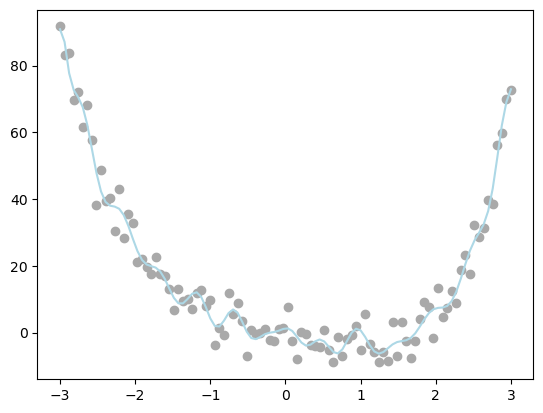

In [4]:
from MyLinearRegression import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

phi = RandomFeatures(n_features= 100)
phi.fit(X)
X_train_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_train_features, y)
pred = LR.predict(X_train_features)
line = pred.numpy() 

plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X, line, color='lightblue', label="Predictions")


## Corrupted Flower Images

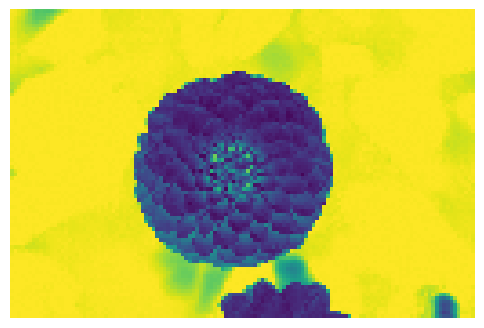

In [5]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

In [6]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

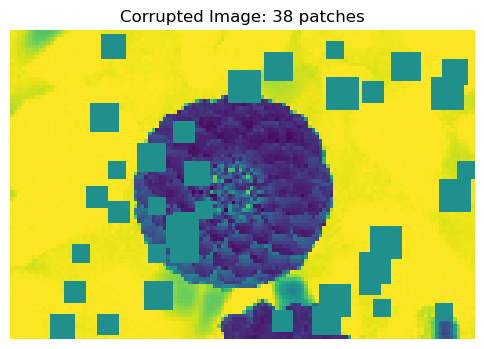

In [7]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In [8]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

In [9]:
from sklearn.model_selection import train_test_split

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Performance of Model

Lowest test loss: 279.7244 at 188 features.


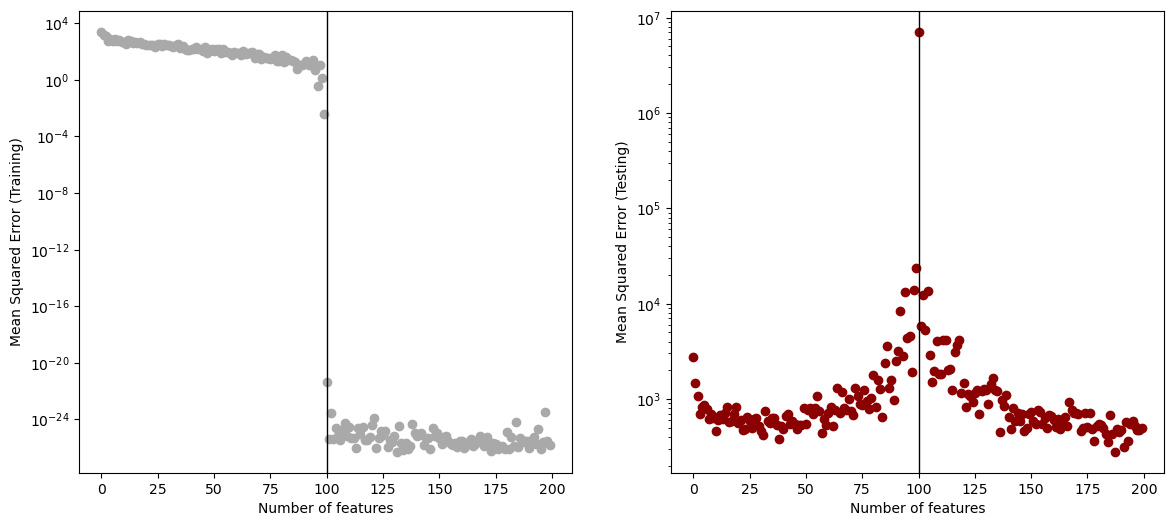

In [ ]:
n_features = 200

train_loss_vec = []
test_loss_vec = []

n = X_train.size()[0] 
for i in range(n_features):
    phi = RandomFeatures(n_features = i, activation = square)
    phi.fit(X_train)
    
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    opt.fit(X_train_phi, y_train)
 
    train_loss = LR.loss(X_train_phi, y_train).item()
    test_loss = LR.loss(X_test_phi, y_test).item()

    train_loss_vec.append(train_loss)
    test_loss_vec.append(test_loss)
   
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  
ax[0].scatter(range(n_features), train_loss_vec, color='darkgrey')
ax[0].set_yscale('log')
ax[0].axvline(n, color='black', linewidth = 1)
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("Mean Squared Error (Training)")

ax[1].scatter(range(n_features), test_loss_vec, color='darkred')
ax[1].set_yscale('log')
ax[1].axvline(n, color='black', linewidth = 1)
ax[1].set_xlabel("Number of features")
ax[1].set_ylabel("Mean Squared Error (Testing)")

best_idx = torch.tensor(test_loss_vec).argmin().item() # convert vector to tensor and get index of minimum
best_features = best_idx + 1 
best_loss = test_loss_vec[best_idx]

print(f"Lowest test loss: {best_loss:.4f} at {best_features} features.")

The best error rate for the testing set was around 280 at 188 features. This was after the interpolation threshold.

## Discussion

My most important finding was the that for the best mse is after the interpolation threshold. For the testing set it was 280 at 188 features. This blog post was my first time to make a fit function for a machine learning model. I also improved my overall graphing skills like a graphing lines on scatter plots and for the interpolation methods. 